<a href="https://colab.research.google.com/github/andreasalvucci/ka-morra/blob/main/convnet_using_tensorflow_for_beginners.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal
* Build and train a Convolutional Neural Network in TensorFlow for a multiclass classification problem of counting fingers using Functional API

In [ ]:
! pip install opendatasets
import opendatasets as od

od.download("https://www.kaggle.com/datasets/koryakinp/fingers")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Skipping, found downloaded files in "./fingers" (use force=True to force download)


In [ ]:
from tqdm.notebook import tqdm

In [ ]:
#  import libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers as tfl
import os
import cv2
from sklearn import preprocessing
from pathlib import Path
from PIL import Image
pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)
pd.options.mode.chained_assignment = None

# Data Preprocessing

The input images are present in the  "train" and "test" folders. 
* Iterate through each folder seperately and store image paths in separate lists 'train_set_path' and 'test_set_path'
* Extract y labels for train and test sets seperately in two lists 'train_set_label' and 'test_set_label' by splitting the filename and collecting the two literals before the dot.
Ex: /input/fingers/test/ef512789-23fb-4da6-ad2e-38780d9cd914_**1L**.png

In [ ]:
#function to extract y labels from base file path
def extract_label(base):
    path = []
    label = []
    for filename in os.listdir(base):
        label.append(filename.split('.')[0][-2:]) #split on dot and read the preceding 2 literals
        path.append(base+filename)
    return path, label

In [ ]:
#base file paths for train and test folders
train_base = "./fingers/train/"
test_base = "./fingers/test/"

#list variables holding file paths and y labels for train and test sets
train_set_path, train_set_label = extract_label(train_base)
test_set_path, test_set_label = extract_label(test_base)

print("Number of training set examples: ", len(train_set_path))
print("Number of test set examples: ", len(test_set_path))

Number of training set examples:  18000
Number of test set examples:  3600


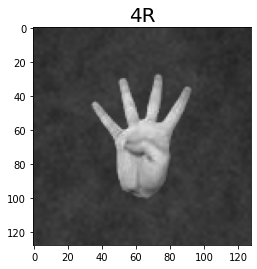

In [ ]:
# Read first image in the training set using opencv api
index=0
image = cv2.imread(train_set_path[index]) 

# display image
plt.imshow(image)
plt.title(train_set_label[index], fontsize = 20)
plt.show()

# Feature Data Train/Test Split

Feature data is split into X_train and X_test by reading images from train and test folders and storing them in lists

In [ ]:
# function to split feature data into train and test 
def feature_data_split(path):
    feature_set = []
    for p in tqdm(path):
        image = cv2.imread(p)
        feature_set.append(image)
    return feature_set

In [ ]:
# read images for train and test set
X_train = feature_data_split(train_set_path)
X_test = feature_data_split(test_set_path)

# convert lists into np arrays to facilitate modelling
X_train = np.array(X_train)
X_test = np.array(X_test)

# check shapes
print(X_train.shape)
print(X_test.shape)

  0%|          | 0/18000 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

(18000, 128, 128, 3)
(3600, 128, 128, 3)


The shapes of X_train and X_test are in expected format i.e, (no of examples, height, width, no of channels)

# Label Data Train/Test Split

The label set has two literal values. ConvNet needs them to be one-hot encoded for modelling. 
* Use Label Encoder from scikit learn to convert labels into unique int values
* Use Keras to one-hot encode the unique values and create a binary matrix representation of y label sets

In [ ]:
# check unique values in train and test sets
print("Train Label set unique values: ", list(np.unique(train_set_label)))
print("Test  Label set unique values: ", list(np.unique(test_set_label)))
if len(np.unique(train_set_label)) == len(np.unique(test_set_label)):
  print("Number of unique classes: ", len(np.unique(train_set_label)))
  num_classes = len(np.unique(train_set_label))

Train Label set unique values:  ['0L', '0R', '1L', '1R', '2L', '2R', '3L', '3R', '4L', '4R', '5L', '5R']
Test  Label set unique values:  ['0L', '0R', '1L', '1R', '2L', '2R', '3L', '3R', '4L', '4R', '5L', '5R']
Number of unique classes:  12


In [ ]:
# apply label encoder to the y train and test sets
label_encoder = preprocessing.LabelEncoder()
y_train = label_encoder.fit_transform(train_set_label)
y_test = label_encoder.fit_transform(test_set_label)

print("Label Encoded Train Label set unique values: ", np.unique(y_train))
print("Label Encoded Test  Label set unique values: ", np.unique(y_test))
if len(np.unique(y_train)) == len(np.unique(y_test)):
  print("Number of unique classes: ", len(np.unique(y_train)))
  num_classes = len(np.unique(y_train))

Label Encoded Train Label set unique values:  [ 0  1  2  3  4  5  6  7  8  9 10 11]
Label Encoded Test  Label set unique values:  [ 0  1  2  3  4  5  6  7  8  9 10 11]
Number of unique classes:  12


In [ ]:
# one hot encode y label train and test sets
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print(y_train.shape)
print(y_test.shape)

(18000, 12)
(3600, 12)


# ConvNet Model Definition, Compilation and Training

The ConvNet will be defined as follows:
* CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> DENSE

Parameters used-
* Conv2D: Use 8 4 by 4 filters, stride 1, padding is "SAME"
* Activatin function  'ReLU'
* MaxPool2D: Use an 8 by 8 filter size and an 8 by 8 stride, padding is "SAME"
* Conv2D: Use 16 2 by 2 filters, stride 1, padding is "SAME"
* Activatin function  'ReLU'
* MaxPool2D: Use a 4 by 4 filter size and a 4 by 4 stride, padding is "SAME"
* Flatten the previous output
* Fully-connected (Dense) layer: Apply a fully connected layer with "num_classes" neurons and a softmax activation for multi-class classification output

In [ ]:
def convolutional_model(input_shape):
    input_img = tf.keras.Input(shape=input_shape)
    conv_layer1 = tfl.Conv2D(filters= 8 , kernel_size= 4 , strides= 1 , padding='same')(input_img)
    activation1 = tfl.ReLU()(conv_layer1)
    pool_layer1 = tfl.MaxPool2D(pool_size=8, strides=8, padding='same')(activation1)
    conv_layer2 = tfl.Conv2D(filters= 16 , kernel_size= 2 , strides= 1 , padding='same')(pool_layer1)
    activation2 = tfl.ReLU()(conv_layer2)
    pool_layer2 = tfl.MaxPool2D(pool_size=4, strides=4, padding='same')(activation2)
    flatten =  tfl.Flatten()(pool_layer2)
    outputs =  tfl.Dense(units=num_classes, activation='softmax')(flatten)
    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model

In [ ]:
# Compile ConvNet model
conv_model = convolutional_model((128, 128, 3))
conv_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
conv_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 8)       392       
                                                                 
 re_lu (ReLU)                (None, 128, 128, 8)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 16)        528       
                                                                 
 re_lu_1 (ReLU)              (None, 16, 16, 16)        0         
                                                             

In [ ]:
# train ConvNet Model
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(128)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(128)

history = conv_model.fit(train_dataset, epochs=5, validation_data=test_dataset)

Epoch 1/5
141/141 [==============================] - 17s 43ms/step - loss: 3.5016 - accuracy: 0.1892 - val_loss: 1.5004 - val_accuracy: 0.5100
Epoch 2/5
141/141 [==============================] - 5s 35ms/step - loss: 0.7826 - accuracy: 0.7447 - val_loss: 0.4409 - val_accuracy: 0.8617
Epoch 3/5
141/141 [==============================] - 5s 33ms/step - loss: 0.3436 - accuracy: 0.8870 - val_loss: 0.2638 - val_accuracy: 0.9139
Epoch 4/5
141/141 [==============================] - 5s 33ms/step - loss: 0.1968 - accuracy: 0.9337 - val_loss: 0.1388 - val_accuracy: 0.9511
Epoch 5/5
141/141 [==============================] - 5s 33ms/step - loss: 0.1099 - accuracy: 0.9614 - val_loss: 0.0869 - val_accuracy: 0.9703


# Model Evaluation

In [ ]:
conv_model.evaluate(X_test, y_test)

113/113 [==============================] - 1s 4ms/step - loss: 0.0869 - accuracy: 0.9703


[0.08689861744642258, 0.9702777862548828]

[Text(0, 0.5, 'Accuracy'), Text(0.5, 0, 'Epoch')]

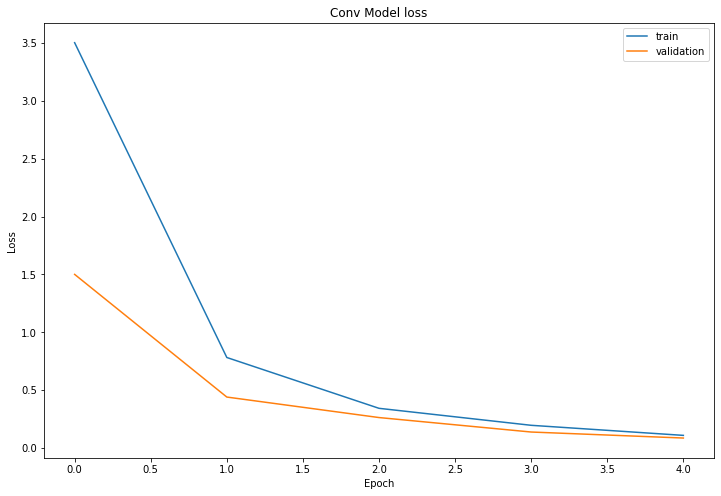

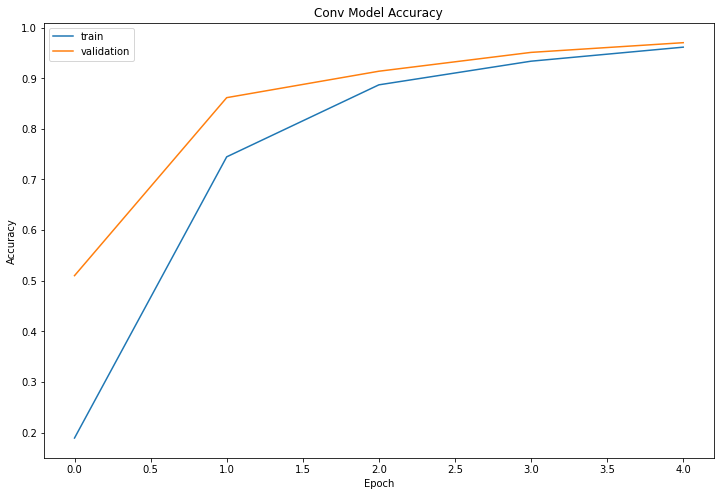

In [ ]:
# plot graphs comparing model loss and accuracy against the number of epochs 
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Conv Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Conv Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')

As we can see, as the number of epochs increase, the loss decreases and the accuracy of the model increases

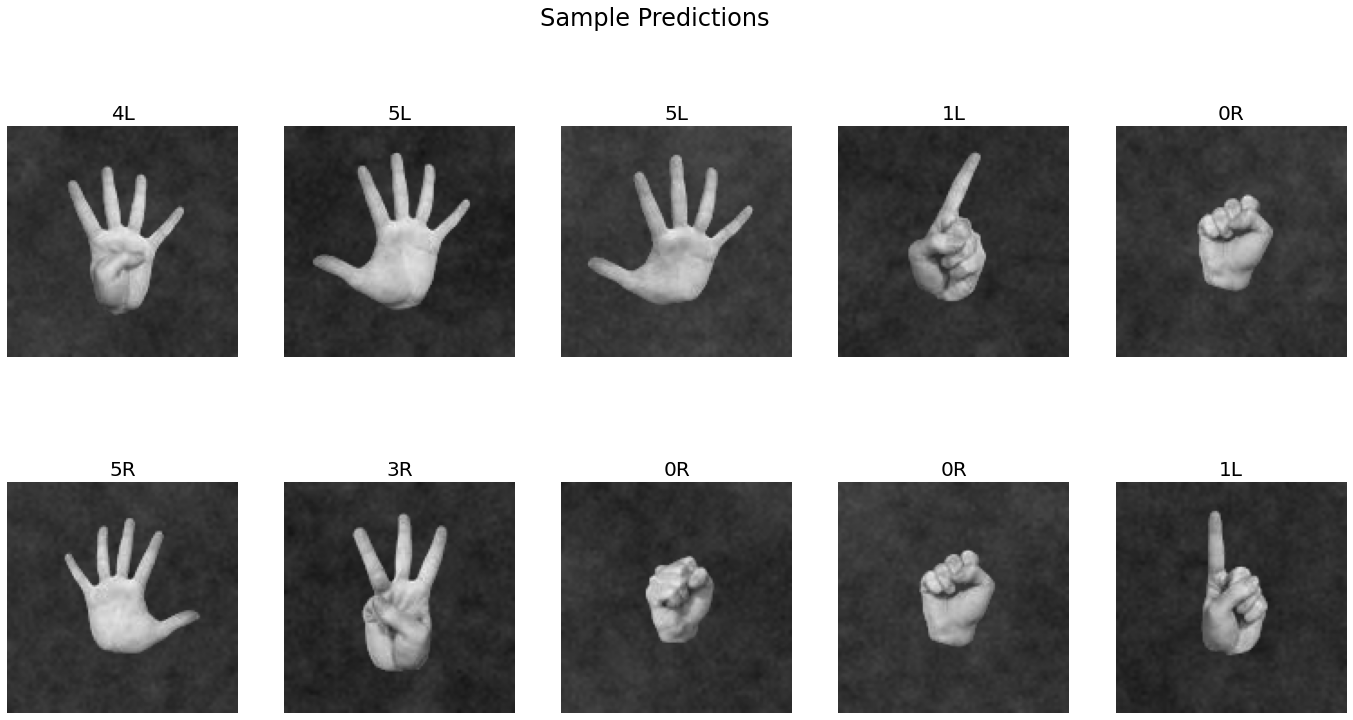

In [ ]:
sample_predictions = conv_model.predict(X_test[:100])
sample_predictions[10:20]
fig, axs= plt.subplots(2,5, figsize=[24,12])


count=20
for i in range(2):    
    for j in range(5):  
        
        img = cv2.imread(test_set_path[count])
        results = np.argsort(sample_predictions[count])[::-1]
        labels = label_encoder.inverse_transform(results) # get the label names using inverse transform
        axs[i][j].imshow(img)
        axs[i][j].set_title(labels[0], fontsize = 20)
        axs[i][j].axis('off')

        count+=1
        
plt.suptitle("Sample Predictions", fontsize = 24)        
plt.show()

# > Thank you for your valuable time!

In [ ]:
def improve_background(img):
  import cv2
  import numpy as np

  hh, ww = img.shape[:2]

  # threshold on white
  # Define lower and uppper limits
  lower = np.array([240, 240, 240])
  upper = np.array([255, 255, 255])

  # Create mask to only select black
  thresh = cv2.inRange(img, lower, upper)

  # apply morphology
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20,20))
  morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

  # invert morp image
  mask = 255 - morph

  # apply mask to image
  result = cv2.bitwise_and(img, img, mask=mask)
  return result

In [ ]:
def bgremove1(myimage):
 
    # Blur to image to reduce noise
    myimage = cv2.GaussianBlur(myimage,(5,5), 0)
 
    # We bin the pixels. Result will be a value 1..5
    bins=np.array([0,51,102,153,204,255])
    myimage[:,:,:] = np.digitize(myimage[:,:,:],bins,right=True)*51
 
    # Create single channel greyscale for thresholding
    myimage_grey = cv2.cvtColor(myimage, cv2.COLOR_BGR2GRAY)
 
    # Perform Otsu thresholding and extract the background.
    # We use Binary Threshold as we want to create an all white background
    ret,background = cv2.threshold(myimage_grey,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
 
    # Convert black and white back into 3 channel greyscale
    background = cv2.cvtColor(background, cv2.COLOR_GRAY2BGR)
 
    # Perform Otsu thresholding and extract the foreground.
    # We use TOZERO_INV as we want to keep some details of the foregorund
    ret,foreground = cv2.threshold(myimage_grey,0,255,cv2.THRESH_TOZERO_INV+cv2.THRESH_OTSU)  #Currently foreground is only a mask
    foreground = cv2.bitwise_and(myimage,myimage, mask=foreground)  # Update foreground with bitwise_and to extract real foreground
 
    # Combine the background and foreground to obtain our final image
    finalimage = background+foreground
 
    return finalimage

In [ ]:
def bgremove2(myimage):
    # First Convert to Grayscale
    myimage_grey = cv2.cvtColor(myimage, cv2.COLOR_BGR2GRAY)
 
    ret,baseline = cv2.threshold(myimage_grey,127,255,cv2.THRESH_TRUNC)
 
    ret,background = cv2.threshold(baseline,126,255,cv2.THRESH_BINARY)
 
    ret,foreground = cv2.threshold(baseline,126,255,cv2.THRESH_BINARY_INV)
 
    foreground = cv2.bitwise_and(myimage,myimage, mask=foreground)  # Update foreground with bitwise_and to extract real foreground
 
    # Convert black and white back into 3 channel greyscale
    background = cv2.cvtColor(background, cv2.COLOR_GRAY2BGR)
 
    # Combine the background and foreground to obtain our final image
    finalimage = background+foreground
    return finalimage

In [ ]:
path_4 = './4.jpg'
path_3 = './3-1.jpg'
path_2 = './2.jpg'
image = cv2.imread(path_2)
image = cv2.resize(image, (128,128))
image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
image = cv2.bitwise_not(image)
image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
print(image.shape)
print(X_test[1].shape)

cv2.imwrite(img=image,filename="togray.jpg")


labels_dict = ['0L','0R','1L','1R','2L','2R', '3L', '3R','4L','4R','5L','5R']

prediction = conv_model.predict(image.reshape(1,128,128,3))
print(labels_dict[np.argmax(prediction)])

error: ignored